## RoboCupHumanoid Setup for Google Colab

In [ ]:
# cleaning
!rm -rf data/
!rm -rf sweaty_1\ \(for\ comparing\)
!rm -rf *.csv *.py *.md *.jpg

### Install Pytorch

In [ ]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q torch==1.0.0 torchvision

In [28]:
!pip install pillow==4.1.1
%reload_ext autoreload
%autoreload
device

device(type='cuda', index=0)

### Clone RoboCupHumanoid

In [6]:
!git clone https://github.com/torayeff/RoboCupHumanoid.git
!mv RoboCupHumanoid/* .
!rm RoboCupHumanoid/ -rf
!mkdir data

Cloning into 'RoboCupHumanoid'...
remote: Enumerating objects: 180, done.
remote: Counting objects: 100% (180/180), done.
remote: Compressing objects: 100% (141/141), done.
remote: Total 180 (delta 80), reused 109 (delta 32), pack-reused 0
Receiving objects: 100% (180/180), 26.54 MiB | 43.97 MiB/s, done.
Resolving deltas: 100% (80/80), done.


### Copy data folder from Google Drive to the current runtime

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
!cp drive/'My Drive'/labivision/data/train.zip data/
!unzip -q data/train.zip -d data/
!rm data/train.zip

### Training

In [1]:
import torch
import torch.nn as nn
import utils as utils
from sweaty_convGru import SweatyNet1
import time
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import peak
import matplotlib.cm as cm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [2]:
modelPath = ''

model = SweatyNet1(device=device)
model.to(device)

if modelPath != '':
    print("Loading Sweaty")
    model.load_state_dict(torch.load(modelPath))


criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

trainset = utils.SoccerBallDataset("data/image_tags/lab3_images/data.csv", "data/image_tags/lab3_images", downsample=4)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)
print(model)

Computing teacher signals...


IndexError: list index out of range

#### Before Training

[['407', '216', '458', '268']]


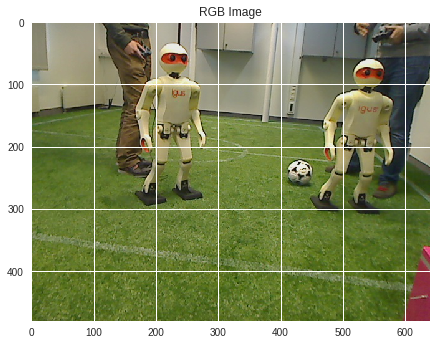

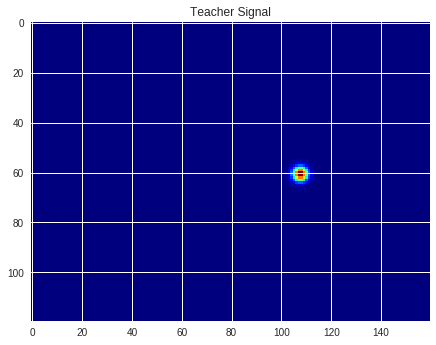

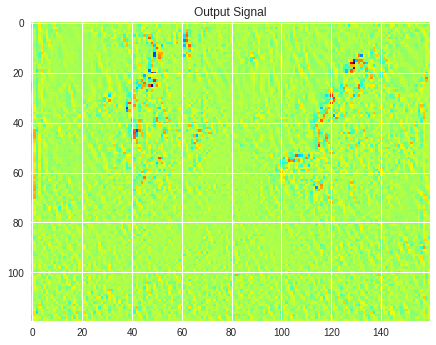

In [8]:
idx = 1

image = trainset[idx]['image']
signal = np.array(trainset[idx]['signal'].squeeze())
print(trainset[idx]['bndboxes'])

output = model(image.unsqueeze(0).float().to(device), None)

output_signal = np.array(output.cpu().squeeze().detach())

plt.title("RGB Image")
plt.imshow(np.array(image).transpose(1, 2, 0))
plt.show()

plt.title("Teacher Signal")
plt.imshow(signal, cmap=cm.jet)
plt.show()


plt.title("Output Signal")
plt.imshow(output_signal, cmap=cm.jet)
plt.show()

In [9]:
epochs = 100
optimizer.zero_grad()

for epoch in range(epochs):
    epoch_loss = 0
    tic = time.time()
    
    for i, data in enumerate(trainloader):
        optimizer.zero_grad()
        
        images = data['image'].float().to(device)
        signals = data['signal'].float().to(device)

        output = model(images)

        loss = criterion(signals[signals.size(0)-1], output)
       
        loss.backward()
        
        optimizer.step()

        epoch_loss += loss.item()
        

    
    epoch_loss /= len(trainset)
    epoch_time = time.time() - tic
    
    print("Epoch: {}, loss: {}, time: {:.5f} seconds".format(epoch + 1, epoch_loss, epoch_time))
    
    if epoch % 10 == 0: 
        torch.save(model.state_dict(), 'pretrained_models/sweaty_GRU_epoch_%d.pth' % (epoch))

Epoch: 1, loss: 0.0021870687140766133, time: 10.70098 seconds
Epoch: 2, loss: 0.00010162930332671426, time: 10.71192 seconds
Epoch: 3, loss: 1.1889179591593127e-05, time: 10.66123 seconds
Epoch: 4, loss: 7.429972577399714e-06, time: 10.68554 seconds
Epoch: 5, loss: 1.542295538630687e-05, time: 10.70608 seconds
Epoch: 6, loss: 4.2862498790421195e-06, time: 10.71062 seconds
Epoch: 7, loss: 1.2545720700479335e-06, time: 10.76275 seconds
Epoch: 8, loss: 9.973395327693355e-07, time: 10.68932 seconds
Epoch: 9, loss: 8.786955933493305e-07, time: 10.74234 seconds
Epoch: 10, loss: 7.852722685567886e-07, time: 10.67954 seconds
Epoch: 11, loss: 7.291117955566011e-07, time: 10.75637 seconds
Epoch: 12, loss: 6.830384355704696e-07, time: 10.67998 seconds
Epoch: 13, loss: 6.501275038317544e-07, time: 10.72436 seconds
Epoch: 14, loss: 6.37129028936415e-07, time: 10.76191 seconds
Epoch: 15, loss: 6.027210318292586e-07, time: 10.72198 seconds
Epoch: 16, loss: 5.811505750137368e-07, time: 10.72550 second

#### After training

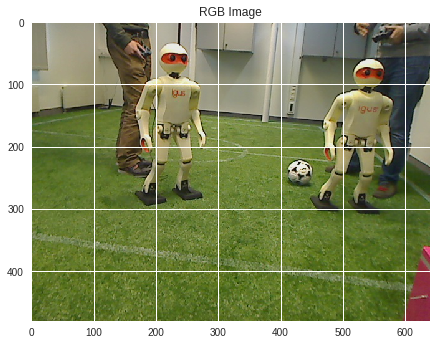

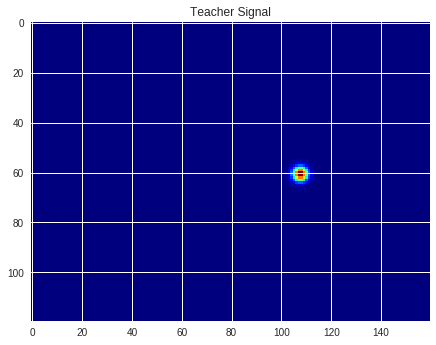

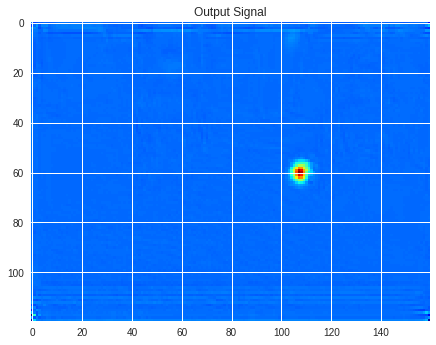

In [3]:
idx = 1
model.to(device)

image = trainset[idx]['image']
signal = np.array(trainset[idx]['signal'].squeeze())

output = model(image.unsqueeze(0).float().to(device))
output_signal = np.array(output.cpu().squeeze().detach())

plt.title("RGB Image")
plt.imshow(np.array(image).transpose(1, 2, 0))
plt.show()

plt.title("Teacher Signal")
plt.imshow(signal, cmap=cm.jet)
plt.show()


plt.title("Output Signal") 
plt.imshow(output_signal, cmap=cm.jet)
plt.show()

In [4]:
utils.evaluate_model(model, device, trainset)

Evaluating model...
Elapsed: 10.524358 sec.
Results:  {'tps': 253, 'fps': 0, 'tns': 0, 'fns': 29}


{'fns': 29, 'fps': 0, 'tns': 0, 'tps': 253}